# Binary classification with logistic regression

- Regression is the hammer we reach for when we want to answer how much? or how many? questions.
- In industry, we’re more often interested in **making categorical assignments**, which is called **classification**.
- binary classification: Let’s call our two categories the positive class y^i=1 and the negative class y^i=0.
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mover>
    <mi>y</mi>
    <mo stretchy="false">&#x005E;<!-- ^ --></mo>
  </mover>
  <mo>=</mo>
  <mi>&#x03C3;<!-- σ --></mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mi mathvariant="bold-italic">w</mi>
    <mi>T</mi>
  </msup>
  <mi mathvariant="bold-italic">x</mi>
  <mo>+</mo>
  <mi>b</mi>
  <mo stretchy="false">)</mo>
  <mo>.</mo>
</math>

- The sigmoid function σ, sometimes called a squashing function or a logistic function - thus the name logistic regression - maps a real-valued input to the range 0 to 1. 
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

-Because the sigmoid outputs a value between 0 and 1, it’s more reasonable to think of it as a probability. Note that an input of 0 gives a value of .5

In [2]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

In [2]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))

In [4]:
x = nd.arange(-5, 5, 1)
y = logistic(x)
x, y

(
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.]
 <NDArray 10 @cpu(0)>, 
 [0.00669285 0.01798621 0.04742587 0.11920292 0.26894143 0.5
  0.7310586  0.880797   0.95257413 0.98201376]
 <NDArray 10 @cpu(0)>)

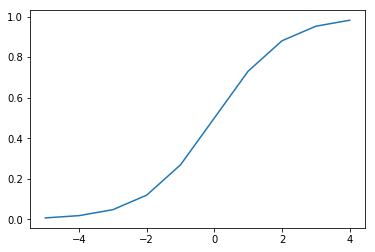

In [5]:
plt.plot(x.asnumpy(), y.asnumpy())

In [10]:
logistic(nd.array([0]))


[0.5]
<NDArray 1 @cpu(0)>

## Binary cross-entropy loss

- log loss (binary cross entropy)
- if $y_i$ is 1 or 0 ...
- a special case of cross-entropy
$$
\ell (\boldsymbol{y}, \boldsymbol{\hat{y}}) =  - \sum_{i=1}^n y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i).
$$



In [13]:
%cd ~/repo/deep-learning
%pwd

/home/zhenglai/repo/deep-learning


'/home/zhenglai/repo/deep-learning'

In [14]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

with open('data/a1a.train') as f:
    train_raw = f.read()

with open('data/a1a.test') as f:
    test_raw = f.read()

In [16]:
train_raw[0], test_raw[0]

('-', '-')

In [30]:
def process_data(raw_data):
    train_lines = raw_data.splitlines()
    num_examples = len(train_lines)
    num_features = 123
    X = nd.zeros((num_examples, num_features), ctx=data_ctx)
    Y = nd.zeros((num_examples, 1), ctx=data_ctx)
    for i, line in enumerate(train_lines):
        tokens = line.split()
        label = (int(tokens[0]) + 1 ) / 2 # change label from {-1, 1} to {0, 1}
        Y[i] = label
        for token in tokens[1:]:
            index = int(token[:-2]) - 1
            X[i, index] = 1
    return X, Y
            

In [32]:
X_train, Y_train = process_data(train_raw)
X_test, Y_test = process_data(test_raw)


In [33]:
X_train.shape, Y_train.shape,  X_test.shape, Y_test.shape

((1605, 123), (1605, 1), (30956, 123), (30956, 1))

In [35]:
nd.sum(Y_train) / len(Y_train), nd.sum(Y_test) / len(Y_test)

(
 [0.24610592]
 <NDArray 1 @cpu(0)>, 
 [0.24053495]
 <NDArray 1 @cpu(0)>)

In [3]:
batch_size = 64
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_train, Y_train),
                                   batch_size=batch_size,
                                   shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_test, Y_test),
                                  batch_size=batch_size,
                                  shuffle=True)

NameError: name 'X_train' is not defined

In [4]:
net = gluon.nn.Dense(1, in_units=123)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

NameError: name 'model_ctx' is not defined

In [40]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

In [44]:
def log_loss(y_pred, y_true):
    yhat = logistic(y_pred)
    return -nd.nansum(y_true * nd.log(yhat) + (1 - y_true) * nd.log(1 - yhat))


In [61]:
nrof_epoch = 1500
losses = []
nrof_examples = len(X_train)

for e in range(nrof_epoch):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            y_pred = net(data)
            loss = log_loss(y_pred, label)
            
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    losses.append(cumulative_loss)
    print('Epoch {}, loss: {}'.format(e, cumulative_loss))

Epoch 0, loss: 529.7440814971924
Epoch 1, loss: 529.7337665557861
Epoch 2, loss: 529.6576271057129
Epoch 3, loss: 529.6718997955322
Epoch 4, loss: 529.6519181728363
Epoch 5, loss: 529.6117503643036
Epoch 6, loss: 529.606360912323
Epoch 7, loss: 529.545517206192
Epoch 8, loss: 529.54570043087
Epoch 9, loss: 529.4981852173805
Epoch 10, loss: 529.5292819142342
Epoch 11, loss: 529.5162823200226
Epoch 12, loss: 529.441172003746
Epoch 13, loss: 529.4758333563805
Epoch 14, loss: 529.4283218383789
Epoch 15, loss: 529.3255271911621
Epoch 16, loss: 529.318289399147
Epoch 17, loss: 529.2971429824829
Epoch 18, loss: 529.2711372375488
Epoch 19, loss: 529.2630590200424
Epoch 20, loss: 529.2225176095963
Epoch 21, loss: 529.1926245689392
Epoch 22, loss: 529.2300015687943
Epoch 23, loss: 529.1673166751862
Epoch 24, loss: 529.1420912742615
Epoch 25, loss: 529.1220030784607
Epoch 26, loss: 529.1118512153625
Epoch 27, loss: 529.0734310150146
Epoch 28, loss: 529.0342526435852
Epoch 29, loss: 529.0005893707

Epoch 242, loss: 524.5209405422211
Epoch 243, loss: 524.4917095154524
Epoch 244, loss: 524.4662261009216
Epoch 245, loss: 524.5030890703201
Epoch 246, loss: 524.4006552696228
Epoch 247, loss: 524.4770169854164
Epoch 248, loss: 524.3930943012238
Epoch 249, loss: 524.3786601424217
Epoch 250, loss: 524.3450455665588
Epoch 251, loss: 524.3499678969383
Epoch 252, loss: 524.3519639968872
Epoch 253, loss: 524.2896661758423
Epoch 254, loss: 524.3273412585258
Epoch 255, loss: 524.3128080368042
Epoch 256, loss: 524.2484385967255
Epoch 257, loss: 524.2274572849274
Epoch 258, loss: 524.223626613617
Epoch 259, loss: 524.2484218478203
Epoch 260, loss: 524.2565447092056
Epoch 261, loss: 524.2244071960449
Epoch 262, loss: 524.176553606987
Epoch 263, loss: 524.2131124138832
Epoch 264, loss: 524.1203994750977
Epoch 265, loss: 524.1185641288757
Epoch 266, loss: 524.0626516342163
Epoch 267, loss: 524.0317611694336
Epoch 268, loss: 524.0300372838974
Epoch 269, loss: 524.0020834207535
Epoch 270, loss: 524.0

Epoch 480, loss: 520.6115403175354
Epoch 481, loss: 520.6669244766235
Epoch 482, loss: 520.6220374107361
Epoch 483, loss: 520.5682973861694
Epoch 484, loss: 520.5603937506676
Epoch 485, loss: 520.5825006961823
Epoch 486, loss: 520.5248473286629
Epoch 487, loss: 520.5331575274467
Epoch 488, loss: 520.5285679101944
Epoch 489, loss: 520.5416829809546
Epoch 490, loss: 520.4667198061943
Epoch 491, loss: 520.4798183441162
Epoch 492, loss: 520.4821605682373
Epoch 493, loss: 520.4826812744141
Epoch 494, loss: 520.4228780269623
Epoch 495, loss: 520.4512084126472
Epoch 496, loss: 520.429164648056
Epoch 497, loss: 520.3684555888176
Epoch 498, loss: 520.3598885536194
Epoch 499, loss: 520.395973265171
Epoch 500, loss: 520.3722486495972
Epoch 501, loss: 520.3256158828735
Epoch 502, loss: 520.2803941965103
Epoch 503, loss: 520.3667426109314
Epoch 504, loss: 520.247142791748
Epoch 505, loss: 520.2580328583717
Epoch 506, loss: 520.2379622459412
Epoch 507, loss: 520.2108361721039
Epoch 508, loss: 520.24

Epoch 717, loss: 517.5810253322124
Epoch 718, loss: 517.5587913990021
Epoch 719, loss: 517.5385738611221
Epoch 720, loss: 517.5250715613365
Epoch 721, loss: 517.4512777328491
Epoch 722, loss: 517.4706082344055
Epoch 723, loss: 517.4478777050972
Epoch 724, loss: 517.4424078464508
Epoch 725, loss: 517.4143664836884
Epoch 726, loss: 517.4536794424057
Epoch 727, loss: 517.3809900283813
Epoch 728, loss: 517.4617130756378
Epoch 729, loss: 517.3735764622688
Epoch 730, loss: 517.429770231247
Epoch 731, loss: 517.3954095840454
Epoch 732, loss: 517.3627977371216
Epoch 733, loss: 517.3994336128235
Epoch 734, loss: 517.3498923778534
Epoch 735, loss: 517.3274788074195
Epoch 736, loss: 517.350040435791
Epoch 737, loss: 517.313318490982
Epoch 738, loss: 517.3200213909149
Epoch 739, loss: 517.2753422260284
Epoch 740, loss: 517.2871840596199
Epoch 741, loss: 517.2628970146179
Epoch 742, loss: 517.2690432965755
Epoch 743, loss: 517.2173402309418
Epoch 744, loss: 517.2183774709702
Epoch 745, loss: 517.23

Epoch 954, loss: 515.0033085346222
Epoch 955, loss: 515.0025110244751
Epoch 956, loss: 514.9063469171524
Epoch 957, loss: 514.9132943153381
Epoch 958, loss: 514.9481866359711
Epoch 959, loss: 514.9338630437851
Epoch 960, loss: 514.977724313736
Epoch 961, loss: 514.9356698989868
Epoch 962, loss: 514.8995576053858
Epoch 963, loss: 514.8986512422562
Epoch 964, loss: 514.9525154829025
Epoch 965, loss: 514.9476925134659
Epoch 966, loss: 514.9174116849899
Epoch 967, loss: 514.8479008078575
Epoch 968, loss: 514.867434501648
Epoch 969, loss: 514.8765622377396
Epoch 970, loss: 514.861466884613
Epoch 971, loss: 514.8542120456696
Epoch 972, loss: 514.7978141009808
Epoch 973, loss: 514.775503218174
Epoch 974, loss: 514.7618486881256
Epoch 975, loss: 514.8192591965199
Epoch 976, loss: 514.7612526416779
Epoch 977, loss: 514.7166053056717
Epoch 978, loss: 514.7487752437592
Epoch 979, loss: 514.7624089717865
Epoch 980, loss: 514.8009572029114
Epoch 981, loss: 514.7222000956535
Epoch 982, loss: 514.678

Epoch 1184, loss: 512.8896524906158
Epoch 1185, loss: 512.8683497905731
Epoch 1186, loss: 512.8557385206223
Epoch 1187, loss: 512.822673022747
Epoch 1188, loss: 512.8305510282516
Epoch 1189, loss: 512.8144409656525
Epoch 1190, loss: 512.8565051555634
Epoch 1191, loss: 512.8013564348221
Epoch 1192, loss: 512.8329104185104
Epoch 1193, loss: 512.7751407623291
Epoch 1194, loss: 512.7881362438202
Epoch 1195, loss: 512.786069393158
Epoch 1196, loss: 512.7522442340851
Epoch 1197, loss: 512.7707762718201
Epoch 1198, loss: 512.7515873908997
Epoch 1199, loss: 512.787168264389
Epoch 1200, loss: 512.7579255104065
Epoch 1201, loss: 512.7581043243408
Epoch 1202, loss: 512.7608940601349
Epoch 1203, loss: 512.6638672351837
Epoch 1204, loss: 512.7056021690369
Epoch 1205, loss: 512.6919660568237
Epoch 1206, loss: 512.6600822210312
Epoch 1207, loss: 512.6663845777512
Epoch 1208, loss: 512.6538226604462
Epoch 1209, loss: 512.6824538707733
Epoch 1210, loss: 512.6389925479889
Epoch 1211, loss: 512.700847029

Epoch 1413, loss: 511.02408373355865
Epoch 1414, loss: 511.0356357097626
Epoch 1415, loss: 511.043395280838
Epoch 1416, loss: 511.0216541290283
Epoch 1417, loss: 510.97139382362366
Epoch 1418, loss: 511.00985538959503
Epoch 1419, loss: 511.04050850868225
Epoch 1420, loss: 510.97447051107883
Epoch 1421, loss: 510.9963321685791
Epoch 1422, loss: 511.0048018693924
Epoch 1423, loss: 510.96837615966797
Epoch 1424, loss: 510.9811475276947
Epoch 1425, loss: 510.995973110199
Epoch 1426, loss: 510.98392605781555
Epoch 1427, loss: 510.9775447845459
Epoch 1428, loss: 510.9014727473259
Epoch 1429, loss: 510.9280502796173
Epoch 1430, loss: 510.97487610578537
Epoch 1431, loss: 510.91967010498047
Epoch 1432, loss: 510.89806365966797
Epoch 1433, loss: 510.88543874025345
Epoch 1434, loss: 510.911736369133
Epoch 1435, loss: 510.864911198616
Epoch 1436, loss: 510.8548200279474
Epoch 1437, loss: 510.89698028564453
Epoch 1438, loss: 510.817943058908
Epoch 1439, loss: 510.825870513916
Epoch 1440, loss: 510.

Text(0,0.5,'average loss')

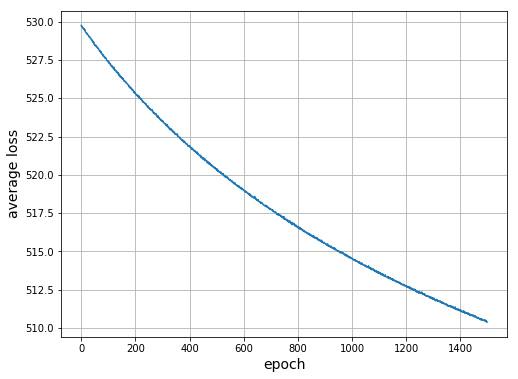

In [62]:
# plot the convergence of the estimated loss function

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(losses)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

In [66]:
nrof_correct = 0.0
nrof_total = len(X_test)
for i, (data, label) in enumerate(test_data):
    data = data.as_in_context(model_ctx)
    label = label.as_in_context(model_ctx)
    y_pred = net(data)
    y_pred = (nd.sign(y_pred) + 1) / 2 # -1, 0, 1
    nrof_correct += nd.sum(y_pred == label)
print('Accuracy: {:.4} ({}/{})'.format(nrof_correct.asscalar() / nrof_total, nrof_correct.asscalar(), nrof_total))

Accuracy: 0.8416 (26052.0/30956)
